# Blind source separation tutorial

1. Introduction
    - Context, applications
    - Mathematical modeling
2. Principal component analysis
3. Independant component analysis
4. Non-negative matrix factorization
5. Sparse matrix factorization: the GMCA example

## 1. Introduction

### Context, applications

What kind of data ? 

- cocktail party problem: recover each audio source from mixtures of them
<img src="img/cocktail_party.png" width="500"/>

- extraction of a foetus' pulse:
<img src="img/ecg.png"/>

- hyperspectral imaging: decompose the data into elementary components related to a signal spectral signature (water, carbone dioxyde, etc.)
<img src="img/hypspec.jpg"/>

- cosmology: recover cosmological signals (e.g. Cosmic Microwave Background, Epoch of the Reionization signal) from multi-wavelength measures
 - observations:
<img src="img/planck.png"/>

 - results:
<img src="img/planck_res.png"/>

### Mathematical modeling

<img src="./img/cocktail_party_model.png"/>

Throughout this tutorial, we assume a <b>linear mixture model</b>:

$$\mathbf{X} = \sum_{k=1}^{n} \mathbf{A}^k \mathbf{S}_k + \mathbf{N} = \mathbf{AS} + \mathbf{N}.$$

<img src="./img/mixture.png"/>

The number of sources is assumed to be known, and smaller than the number of observations. The noise is Gaussian, independant and identically distributed.

The objective is to jointly estimate $\mathbf{A}$ and $\mathbf{S}$ from $\mathbf{X}$.

What cannot be avoided during the blind source separation:

- permutations between the sources: 
$$\mathbf{X} = \sum_{k=1}^{n} \mathbf{A}^k \mathbf{S}_k = \sum_{k=1}^{n} \mathbf{A}^{\sigma(k)} \mathbf{S}_{\sigma(k)},$$

- scaling issues:
$$\mathbf{X} = \sum_{k=1}^{n} \mathbf{A}^k \mathbf{S}_k = \sum_{k=1}^{n} (\lambda_k \mathbf{A}^{k}) (\mathbf{S}_{k}/\lambda_k).$$

These limitations will be illustrated later in this tutorial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bss
import ffttools as fftt

plt.rcParams.update({'font.size': 14})

## 2. Principal Component Analysis
This is a statistical method. 

<u>Hypothesis:</u> the sources are <b>uncorrelated</b>.

First, let's generate the data (with no noise to begin). We consider n = 2 sources and m = 2 observations in order to have a geometrical interpretation of the different steps.

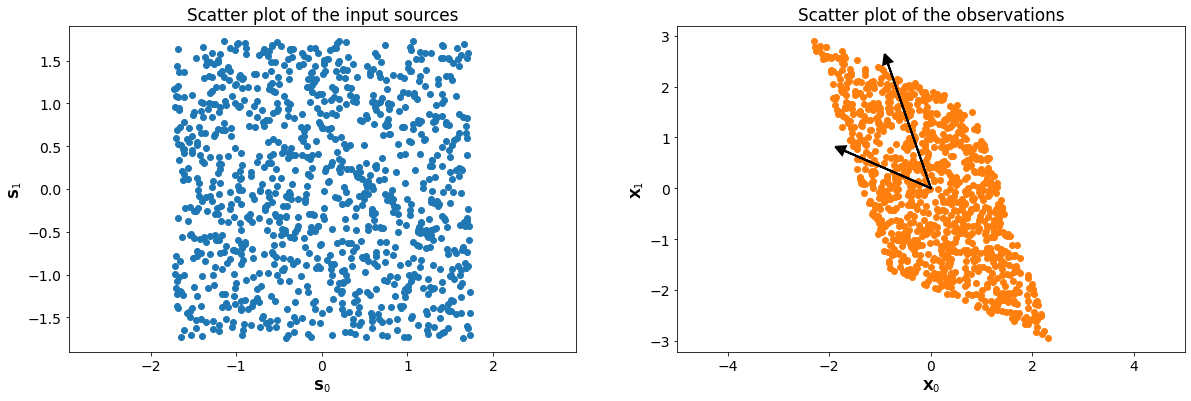

In [10]:
# Generate data

n = 2         # number of sources
m = 2         # number of observations
t = 1024      # number of samples

s_type = 2    # uniform random sources

X, A, S = bss.makeMixture(s_type=s_type, n=n, m=m, t=t)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations')
vrange = 0.5*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The arrows on the plot above are the columns of $\mathbf{A}$.

Decorrelation can be measured via the covariance matrix of the estimated sources: it should be diagonal (uncorrelated sources hypothesis).

Let $\mathbf{R_M}$ denote the covariance matrix of a matrix $\mathbf{M}$. We have: $\mathbf{R_X} = \mathbf{XX}^T = \mathbf{ASS}^T\mathbf{A}^T = \mathbf{A}\mathbf{R_S}\mathbf{A}^T$.

PCA simply performs a diagonalization of $\mathbf{R_X}$: $\mathbf{R_X} = \mathbf{UDU}^T$ from which we identify $\mathbf{A} = \mathbf{U}$ and deduce $\mathbf{S} = \mathbf{A}^{-1}\mathbf{X} = \mathbf{A}^T \mathbf{X}$.

Covariance matrix of the estimated sources by PCA:
 [[ 4.40239858e-01 -6.98908727e-17]
 [-6.98908727e-17  2.40764096e+00]]


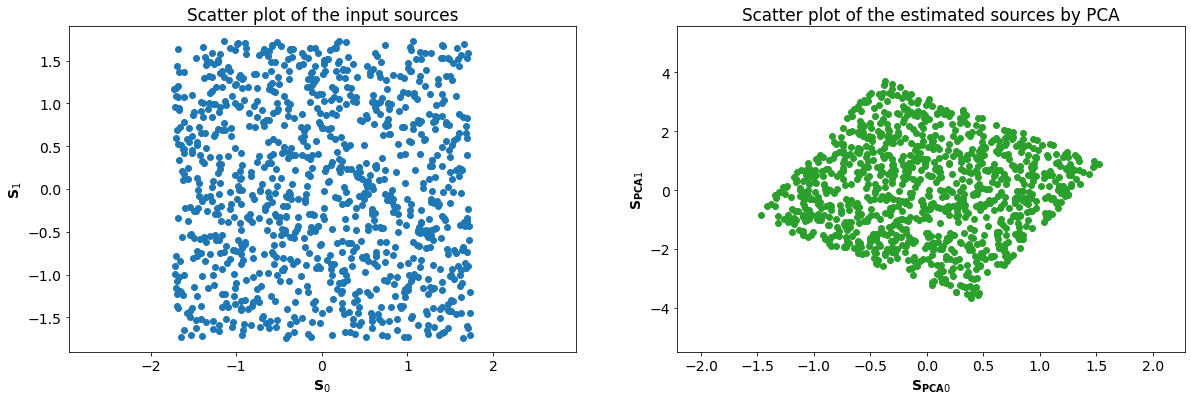

In [11]:
# Unmix sources with PCA

A_pca, S_pca = bss.pca(X, n)

Mrange = 1.5*np.max(S_pca, 1)
mrange = 1.5*np.min(S_pca, 1)
vrange = 0.5*max([max(abs(Mrange)),max(abs(mrange))])

G = np.linalg.pinv(A_pca)@A

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by PCA')
#plt.arrow(0, 0, vrange*G[0,0], vrange*G[1,0], fc="k", ec="k", linewidth=2,head_width=0.1*vrange, head_length=0.1*vrange)
#plt.arrow(0, 0, vrange*G[0,1], vrange*G[1,1], fc="k", ec="k", linewidth=2,head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(S_pca[0,:], S_pca[1,:], 'C2o', zorder=0)
plt.xlabel("$\mathbf{S_{PCA}}_0$")
plt.ylabel("$\mathbf{S_{PCA}}_1$")
plt.axis([mrange[0], Mrange[0], mrange[1], Mrange[1]]);
print('Covariance matrix of the estimated sources by PCA:\n', np.cov(S_pca))

The estimated sources are not correlated. Yet, the solution is not satisfactory.

Limitations:
- the estimated mixing matrix can only be orthogonal,
- different uncorrelated solutions exist (consider $\mathbf{S}' = \mathbf{US}$ where $\mathbf{UU}^T = \mathbf{I}$).

## 3. Independant Component Analysis
This is a statistical method. 

<u>Hypotheses:</u> 
- the sources are <b>independant</b>,
- at most one source is Gaussian.

Let us generate the data. We consider here two sources with different distributions.

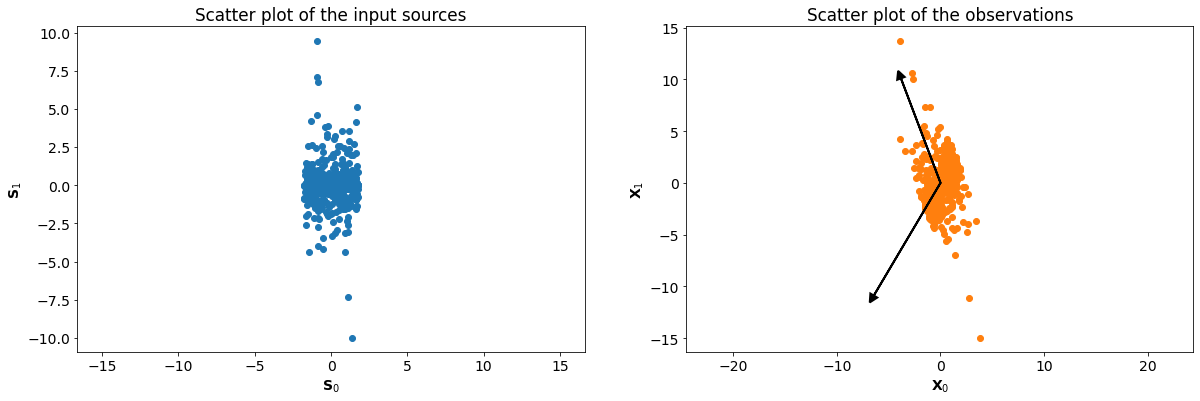

In [30]:
# Generate data

n = 2         # number of sources
m = 2         # number of observations
t = 1024      # number of samples

s_type = [2, 3]    # uniform and sparse random sources

X, A, S = bss.makeMixture(s_type=s_type, n=n, m=m, t=t)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations')
vrange = 0.5*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The central limit theorem states that the properly normalized sum of independant random variables tends towards a normal distribution. 

In the context of BSS, mixing the sources tend to "gaussianize" the observations. To illustrate this, below are the histograms of the sources and the observations. The effect of the "gaussianization" here is quite limitied because there are only two sources.

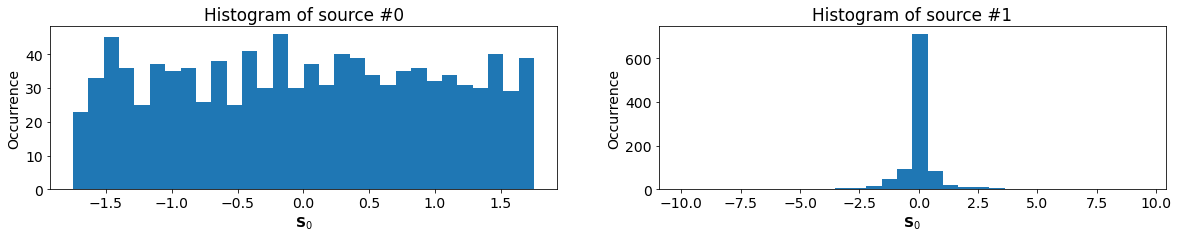

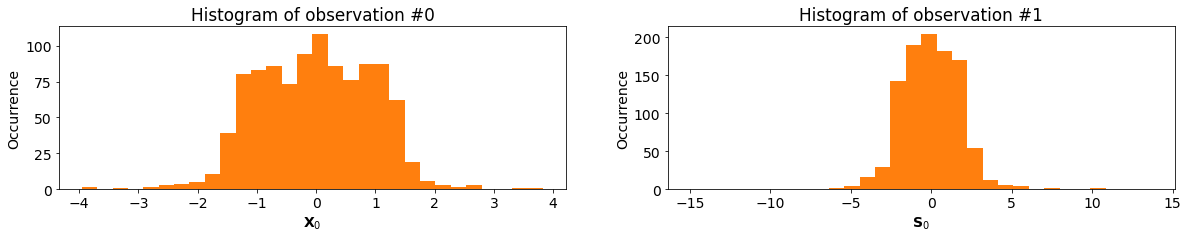

In [31]:
fig = plt.figure(figsize=(20, 3))
fig.add_subplot(1,2,1)
plt.hist(S[0, :], color='C0', bins=30)
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of source #0');
fig.add_subplot(1,2,2)
plt.hist(S[1, :], color='C0', bins=30)
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of source #1');
fig = plt.figure(figsize=(20, 3))
fig.add_subplot(1,2,1)
plt.hist(X[0, :], color='C1', bins=30)
plt.xlabel('$\mathbf{X}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of observation #0');
fig.add_subplot(1,2,2)
plt.hist(X[1, :], color='C1', bins=30)
plt.xlabel('$\mathbf{S}_0$')
plt.ylabel('Occurrence')
plt.title('Histogram of observation #1');

The basic idea of ICA is to use the non-gaussianity of the sources as a proxy for their independance; in other words, the "non-gaussianity" of the sources is maximized in ICA.

Several ICA methods exist, they differ on the kind of measure of independance. We can cite:
- infomax (minimize the mutual information between the sources),
- JADE (diagonalize the 4th order cumulant tensor of the sources),
- FastICA (maximize the negentropy of the sources).

Let us test FastICA.

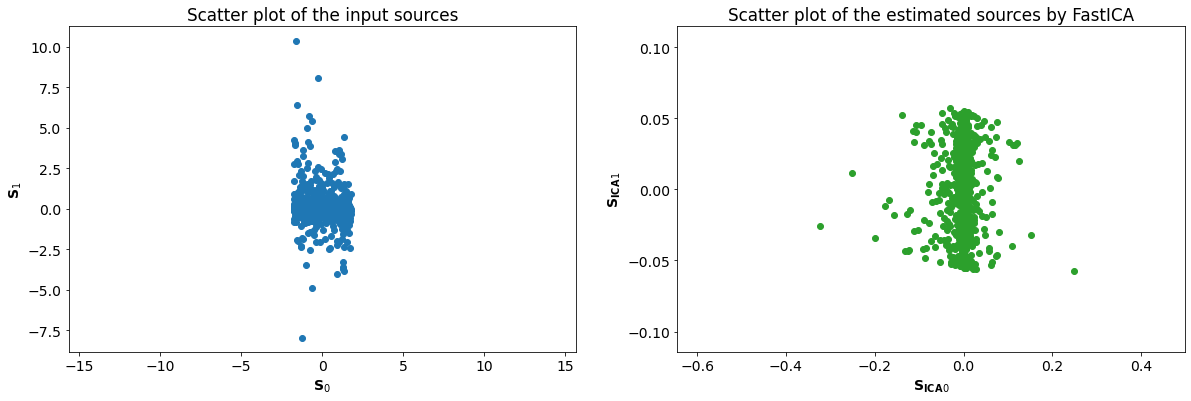

In [43]:
# Unmix sources with FastICA

A_fpica,S_fpica = bss.fastica(X,n)

S_fpica = np.linalg.pinv(A_fpica)@X

S_fpica = np.diag(1/np.sqrt(np.sum(S_fpica**2,axis=1)))@S_fpica

Mrange = 2*np.max(S_fpica,1)
mrange = 2*np.min(S_fpica,1)
vrange = 0.5*max([max(abs(Mrange)),max(abs(mrange))])

G = np.linalg.pinv(A_fpica)@A

G = np.diag(1./np.sqrt(np.sum(G*G,axis=1)))@G

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by FastICA')
plt.plot(S_fpica[0,:],S_fpica[1,:], 'C2o', zorder=0)
plt.xlabel("$\mathbf{S_{ICA}}_0$")
plt.ylabel("$\mathbf{S_{ICA}}_1$")
plt.axis([mrange[0], Mrange[0], mrange[1], Mrange[1]]);

We can clearly see above the effect the permutation and scale indeterminacies. Indeed:
- the estimated sources are not ordered in the same manner as the input sources,
- the scale of the estimated sources is wrong.

We can use the knowledge of the ground truth sources to solve these indeterminacies.

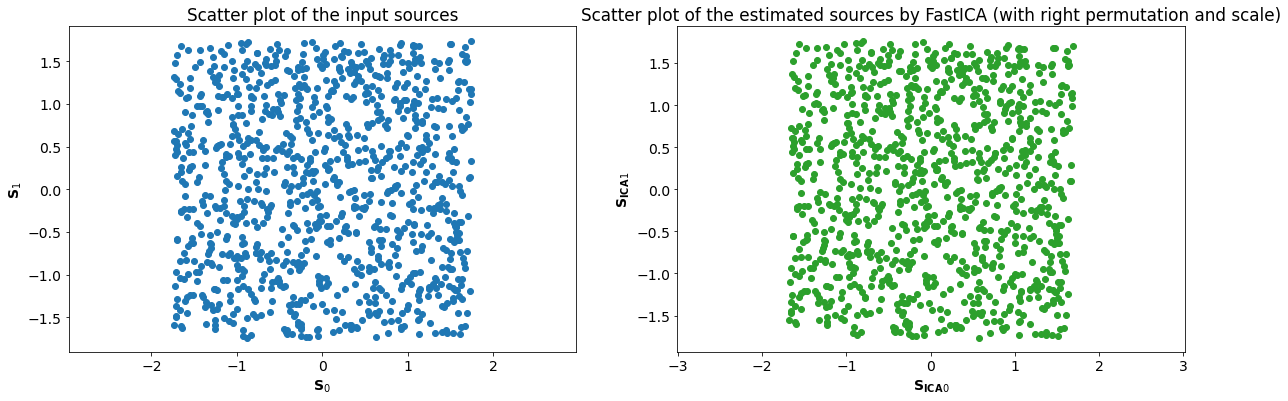

In [6]:
bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by FastICA (with right permutation and scale)')
plt.plot(S_fpica[0,:],S_fpica[1,:], 'C2o', zorder=0)
plt.xlabel("$\mathbf{S_{ICA}}_0$")
plt.ylabel("$\mathbf{S_{ICA}}_1$")
plt.axis('equal');

ICA does not take into account the noise contamination. Consequently, it is not very robust with noise. 

Let us define two performance metrics, which evaluate the reconstruction quality of the estimated sources $\mathbf{\hat{S}}$ and mixing matrix $\mathbf{\hat{A}}$ (the higher, the better):

$$\text{NMSE} = -20 \log{\dfrac{\left\lVert\mathbf{S}-\mathbf{\hat{S}}\right\rVert}{\left\lVert\mathbf{S}\right\rVert}}$$

$$\text{CA} = -20 \log{\text{mean}(\mathbf{A}^+\mathbf{\hat{A}}-\mathbf{I})}$$

In [ ]:
Let us evaluate the evolution of these metrics with respect to the noise level which contaminates the observations.

/Users/rcarlonigert/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


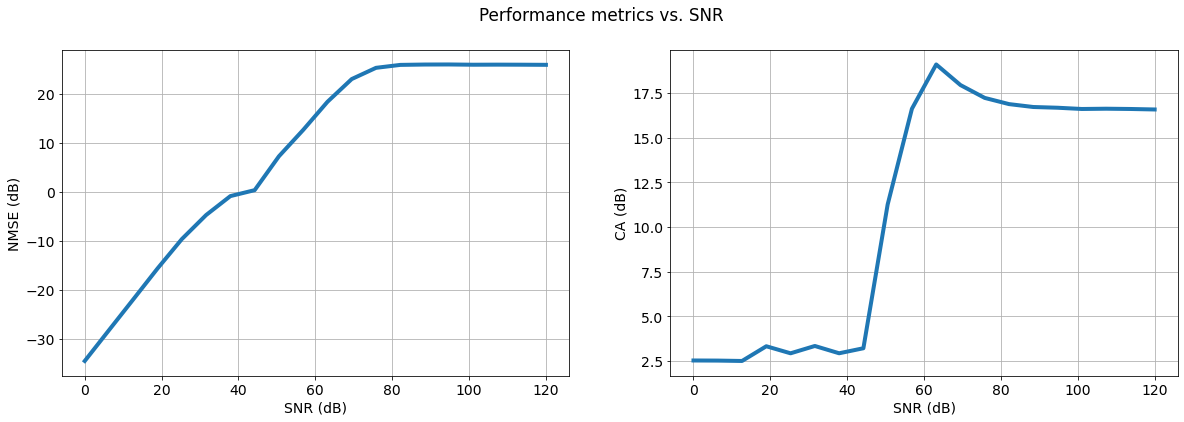

In [7]:
npoints = 20
snrs = np.linspace(0, 120, npoints)
stds = np.linalg.norm(X, 'fro')*10**(-snrs/20)
N = np.random.randn(m, t)
nmses = np.zeros(npoints)
cas = np.zeros(npoints)
for i, std in enumerate(stds):
    Xn = X + std*N
    A_fpica, S_fpica = bss.fastica(Xn, n)
    bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)
    nmses[i] = bss.nmse(S, S_fpica)
    cas[i] = bss.ca(A, A_fpica)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Performance metrics vs. SNR')
fig.add_subplot(1,2,1)
plt.plot(snrs, nmses, linewidth=4)
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE (dB)')
plt.grid()

fig.add_subplot(1,2,2)
plt.plot(snrs, cas, linewidth=4)
plt.xlabel('SNR (dB)')
plt.ylabel('CA (dB)')
plt.grid()

## 4. Non-negative matrix factorization (NMF)
<u>Hypothesis:</u> the sources and the mixing matrix are non-negative

<u>Examples:</u> hyperspectral imaging, nuclear magnetic resonance spectroscopy, etc.

Let us generate non-negative data.

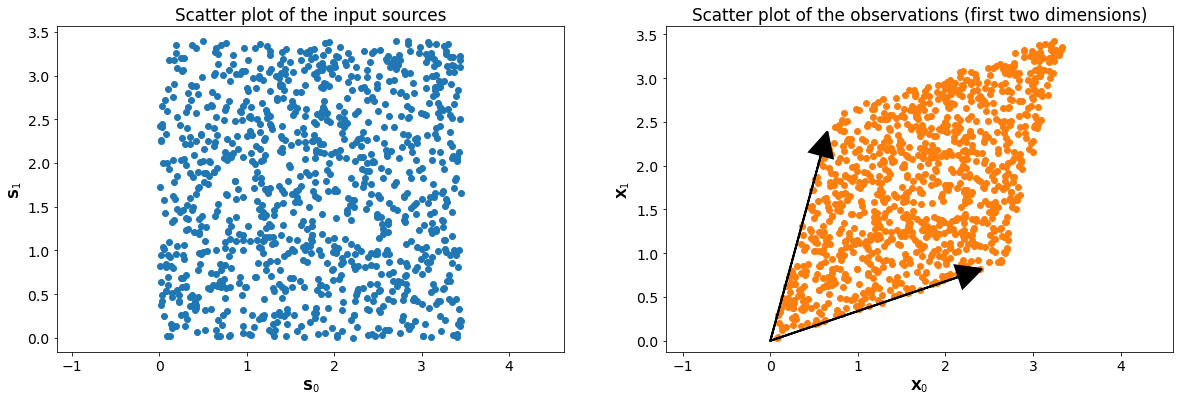

In [35]:
# Generate data

n = 2         # number of sources
m = 8         # number of observations
t = 1024      # number of samples

s_type = 2

X, A, S = bss.makeMixture(s_type=s_type, nneg=True, n=n, m=m, t=t)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
#means = np.mean(X, axis=1)
plt.arrow(0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow(0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

There are commonly two types of approaches to solve NMF problems.

### Geometric approach (not tackled in this tutorial)

The convex cone generated by a set of vectors $\{\mathbf{s}_i, i\in[1,n]\}$ is defined by $\mathcal{C} = \left\{\mathbf{x} = \sum\limits_{i=1}^{n} a_i \mathbf{s}_i, \forall i\in[1,n], a_i\in\mathbb{R}^+\right\}$.

In the context of NMF, due to the non-negative hypotheses, the observations belong to the convex cone generated by the sources, which itself is included in the positive orthant.

<img src="img/geo_approach.png" width="600"/>

The geometric approaches aim at finding a convex cone within the positive orthant that contains all the observations. If the observations are projected on the simplex plane, the problem can be recast as finding a polytope which contains all the observations. 

<img src="img/geo_approach_2.png" width="600"/>

If, for each source, there is at least one sample where this source only is active, it is possible to perform the separation exactly. This is known as the pure-pixel assumption.

### Optimization approach

Minimize a cost function:
$$\min\limits_{\mathbf{A}\geq0,\mathbf{S}\geq0} \text{D}(\mathbf{X}, \mathbf{AS}),$$
where D is a divergence (e.g. Euclidian distance or Kullback-Leibler divergence) and $\mathbf{M}\geq0$ means that the coefficients of $\mathbf{M}$ are non-negative.

A standard minimization procedure is the "multiplicative update" (Lee & Seung 1999). At each iteration, $\mathbf{A}$ and $\mathbf{S}$ in a way that decreases the cost function. For instance, in the case of the Euclidian distance ($\text{D} = ||\mathbf{X} -\mathbf{AS}||^2_\text{F}$), the updates are:
- $\mathbf{S}_i^j \leftarrow \mathbf{S}_i^j \dfrac{(\mathbf{A}^T\mathbf{X})_i^j}{(\mathbf{A}^T\mathbf{AS})_i^j}$
- $\mathbf{A}_i^j \leftarrow \mathbf{A}_i^j \dfrac{(\mathbf{XS}^T)_i^j}{(\mathbf{ASS}^T)_i^j}$

Another popular algorithm is Hierarchical Alternating Least Squares or HALS (Cichocki, 2007). It is also implemented by a multiplicative update, but the columns of $\mathbf{A}$ and the lines of $\mathbf{S}$ are updated one by one iteratively.

Let us compare these two methods.

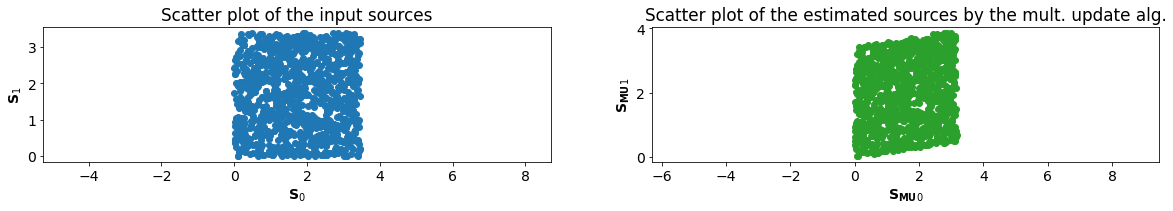

In [42]:
# Unmix the sources with the multiplicative update algorithm

A_mu, S_mu = bss.multiplicative_update(X, n)
bss.corr_perm(A, S, A_mu, S_mu, inplace=True)

fig = plt.figure(figsize=(20, 2.5))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by the mult. update alg.')
plt.plot(S_mu[0,:], S_mu[1,:],'C2o',zorder=0)
plt.xlabel("$\mathbf{S_{MU}}_0$")
plt.ylabel("$\mathbf{S_{MU}}_1$");
plt.axis('equal');

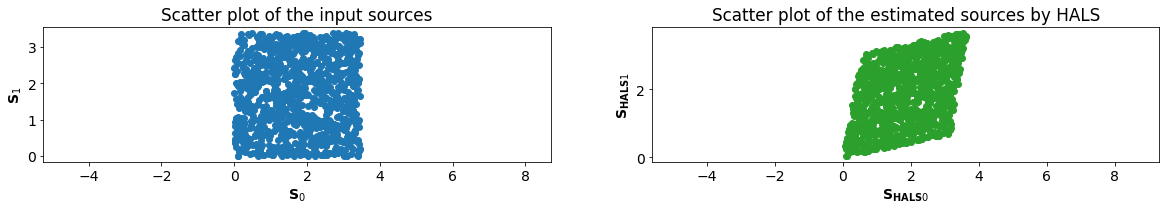

In [43]:
# Unmix the sources with HALS

A_hals, S_hals = bss.hals(X, n=n)
bss.corr_perm(A, S, A_hals, S_hals, inplace=True)

fig = plt.figure(figsize=(20, 2.5))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');


fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by HALS')
plt.plot(S_hals[0,:], S_hals[1,:],'C2o',zorder=0)
plt.xlabel("$\mathbf{S_{HALS}}_0$")
plt.ylabel("$\mathbf{S_{HALS}}_1$");
plt.axis('equal');

In [38]:
print("Multiplicative update:\n- NMSE: %.2f dB\n- CA: %.2f dB\n" % (bss.nmse(S, S_mu), bss.ca(A, A_mu)))
print("HALS:\n- NMSE: %.2f dB\n- CA: %.2f dB" % (bss.nmse(S, S_hals), bss.ca(A, A_hals)))

Multiplicative update:
- NMSE: 8.44 dB
- CA: 7.29 dB

HALS:
- NMSE: 19.68 dB
- CA: 9.16 dB


## Sparse matrix factorization: the GMCA example
The sources must verify two hypotheses.

<ins>First hypothesis</ins>: the sources are sparse in a given transformed domain (ie. most samples are zero-valued) 


For the sake of simplicity, we assume hereinbelow that the sources are sparse in the direct domain. 

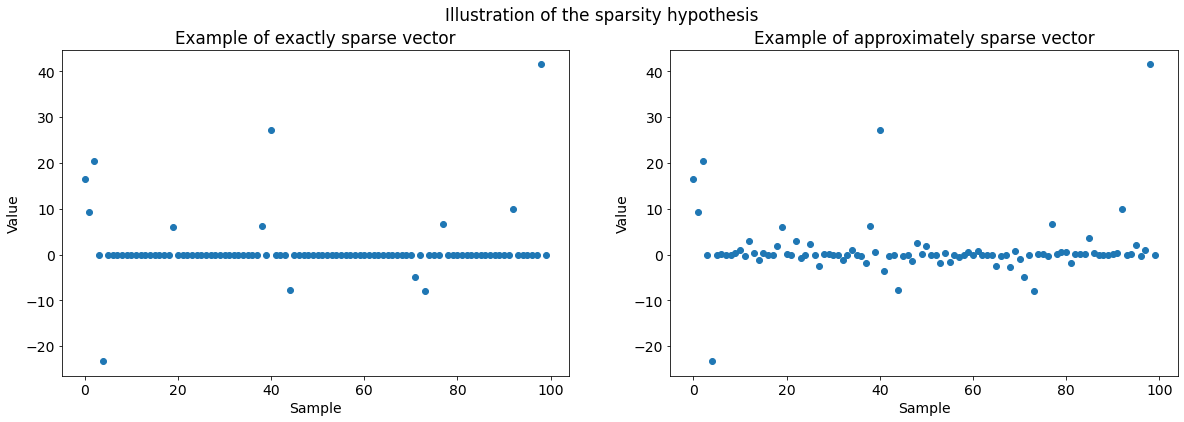

In [12]:
approx_sparse = np.random.randn(100)**3
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.suptitle('Illustration of the sparsity hypothesis')
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

<ins>Second hypothesis</ins>: the sources are morphologically diverse (ie. the non-zero samples of the sources are on different locations, in other words the supports of the sources are disjoint)

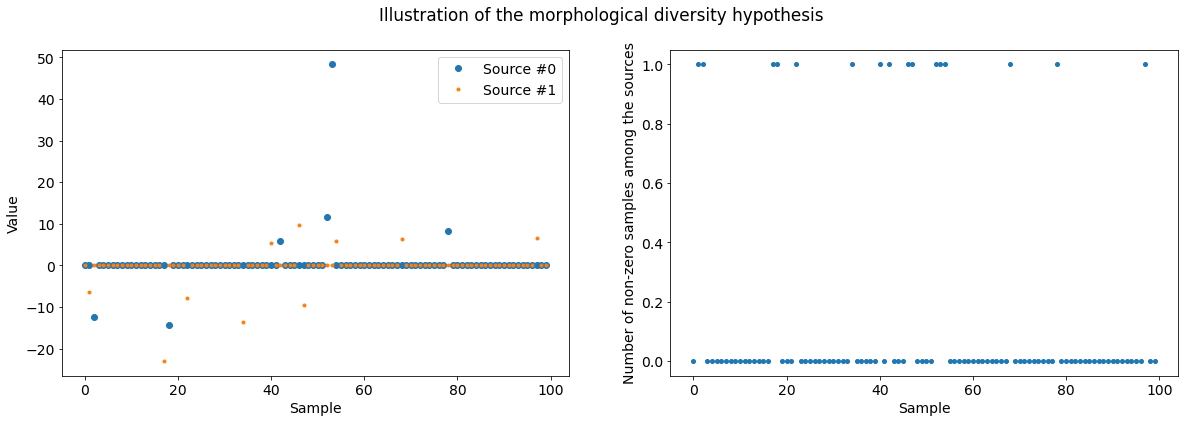

In [13]:
S = np.random.randn(2, 100)**3
S = S*(np.abs(S)>5)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Illustration of the morphological diversity hypothesis');
fig.add_subplot(1,2,1)
plt.plot(S[0, :], 'C0.', markerSize=12, label='Source #0')
plt.plot(S[1, :], 'C1.', markerSize=6, label='Source #1')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()

fig.add_subplot(1,2,2)
plt.plot(np.sum(S!=0, axis=0), '.', markerSize=8)
plt.xlabel('Sample')
plt.ylabel('Number of non-zero samples among the sources');

Let us generate the sources, mixing matrix and observations (with a 80 dB noise).

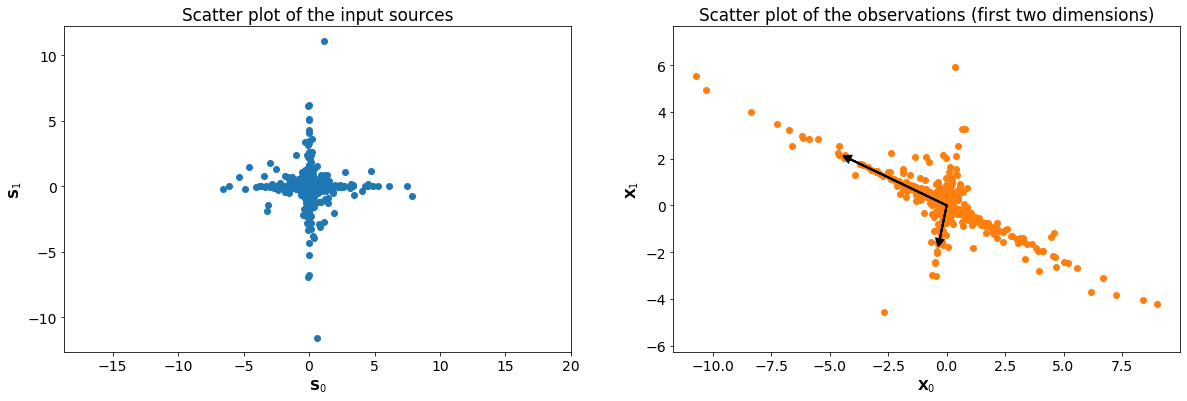

In [12]:
n = 2         # number of sources
m = 2         # number of observations
t = 1024      # number of samples

s_type = 3   # approximately sparse sources

X, A, S = bss.makeMixture(s_type=s_type, n=n, m=m, t=t, noise_level=80)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

The GMCA algorithm aims at minimizing the following cost function:

$$\min\limits_{\mathbf{A}, \mathbf{S}} ||\mathbf{X}-\mathbf{AS}||_2 + \sum_{i=0}^{n} \lambda_i ||\mathbf{S}_i||_{0/1} $$

The resolution relies on an projected alternate least-square procedure. Iteratively:

1. Update of $\mathbf{S}$ with $\mathbf{A}$ fixed<br>
    1.1 Least-square update: $\mathbf{S} \leftarrow \mathbf{A}^+ \mathbf{X}$<br>
    1.2 Calculation of the thresholds: $\lambda_i = k~\text{mad}(\mathbf{S}_i)$<br>
    1.3 Thresholding: $\mathbf{S}_i \leftarrow \mathcal{T}_{\lambda_i}(\mathbf{S})$<br>


2. Update of $\mathbf{A}$ with $\mathbf{S}$ fixed<br>
    2.1 Least-square update: $\mathbf{A} \leftarrow \mathbf{X} \mathbf{S}^+$<br>
    2.2 Normalization: $\mathbf{A}^j \leftarrow \dfrac{\mathbf{A}^j}{||\mathbf{A}^j||_2}$<br>

The key point is the <b>thresholding</b>. It allows to keep the samples with the highest amplitudes, which are the most discrimative/informative to retrieve the mixing matrix. Indeed:
- due to the morphological assumption, they mostly belong to only one source,
- they are less contaminated by the noise.

The advantage of GMCA is to propose an <b>automatic and adaptative calculation of the thresholds</b>, using the median absolute deviator (mad). It can be showed that the resulting thresholds decrease along the iterations, which provides robustness in terms of convergence. 

Let us illustrate the estimated sources by GMCA along the iterations.

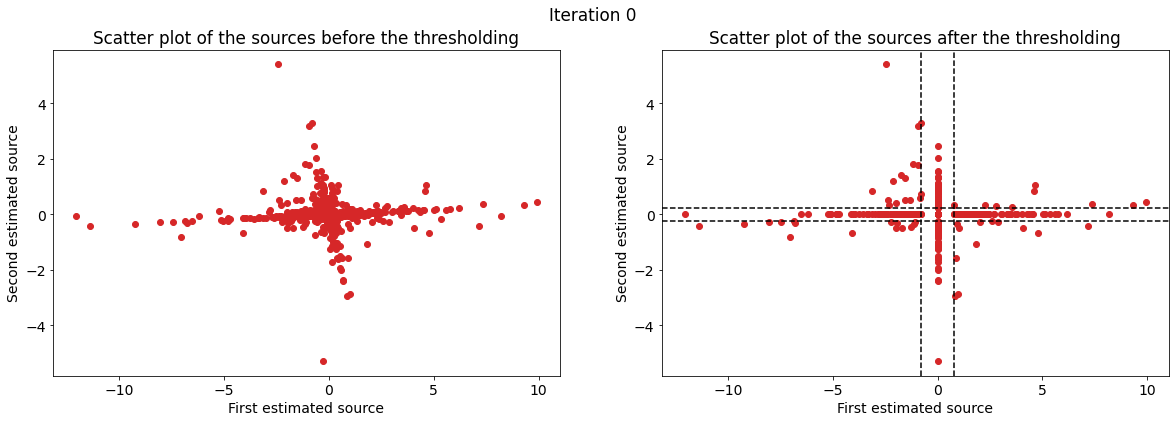

In [13]:
A_gmca, S_gmca, As_gmca, Ss_gmca, thrds = bss.gmca_getDetails(X, n)
nb_its = np.shape(As_gmca)[0]
i = 2
its = np.linspace(0, nb_its-1, 6)

it = its[0]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

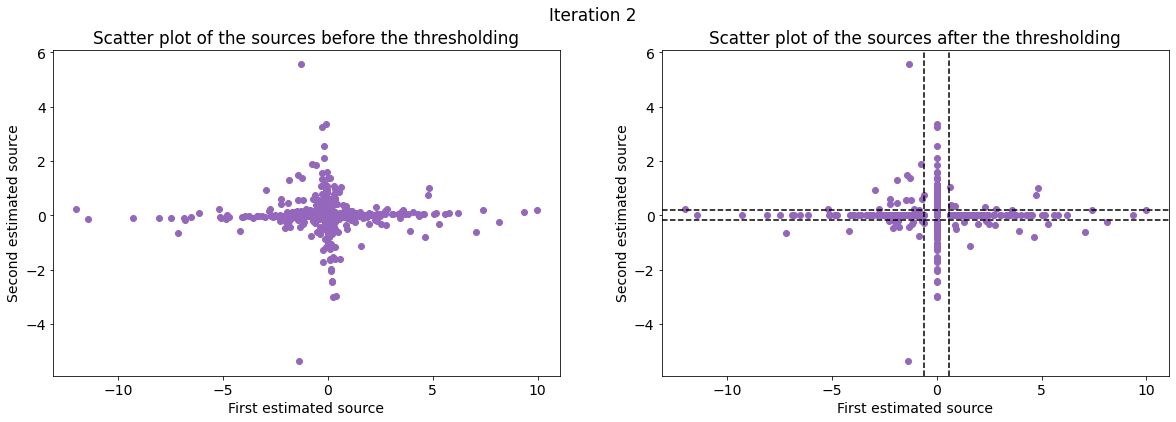

In [14]:
it = its[1]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

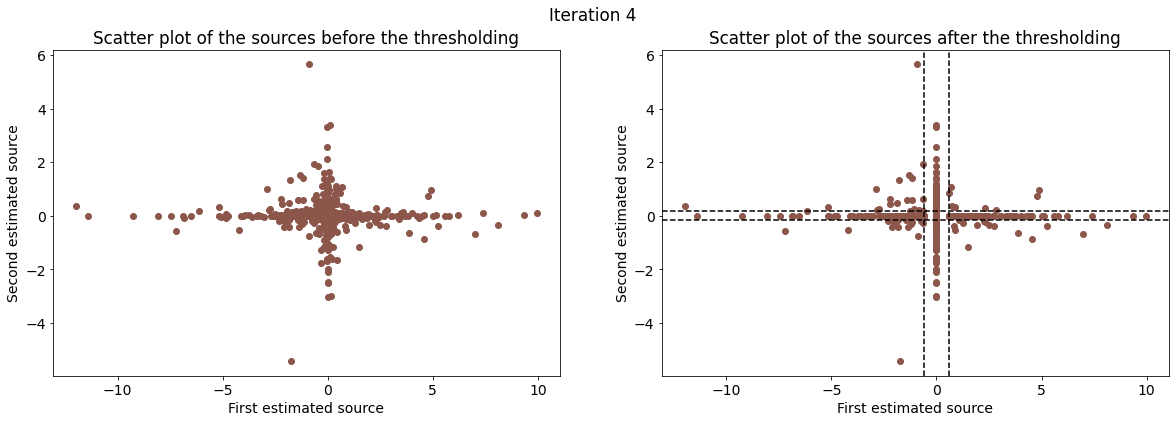

In [15]:
it = its[2]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

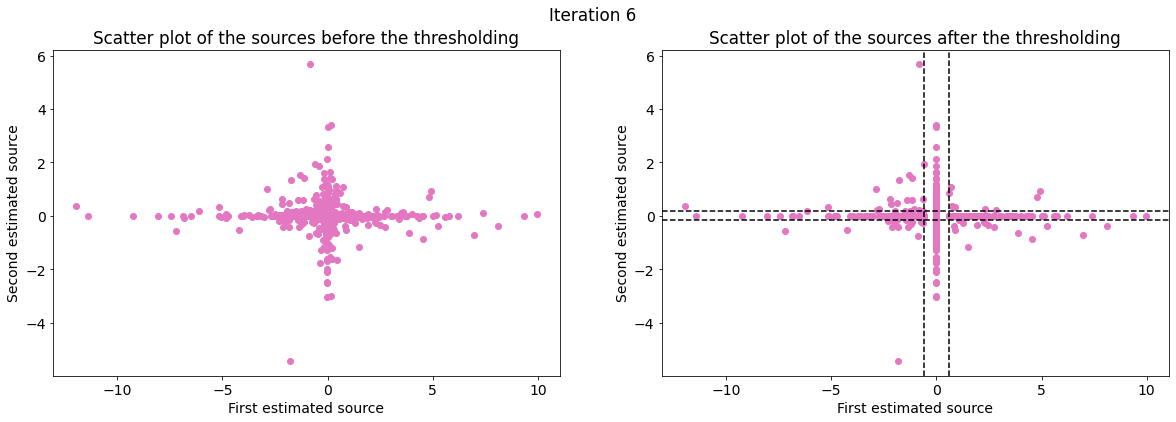

In [16]:
it = its[3]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

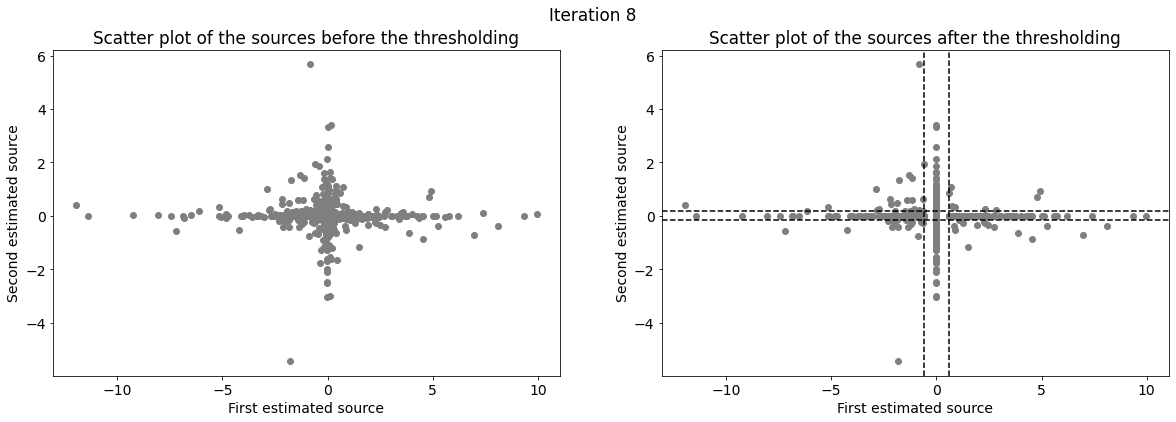

In [17]:
it = its[4]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

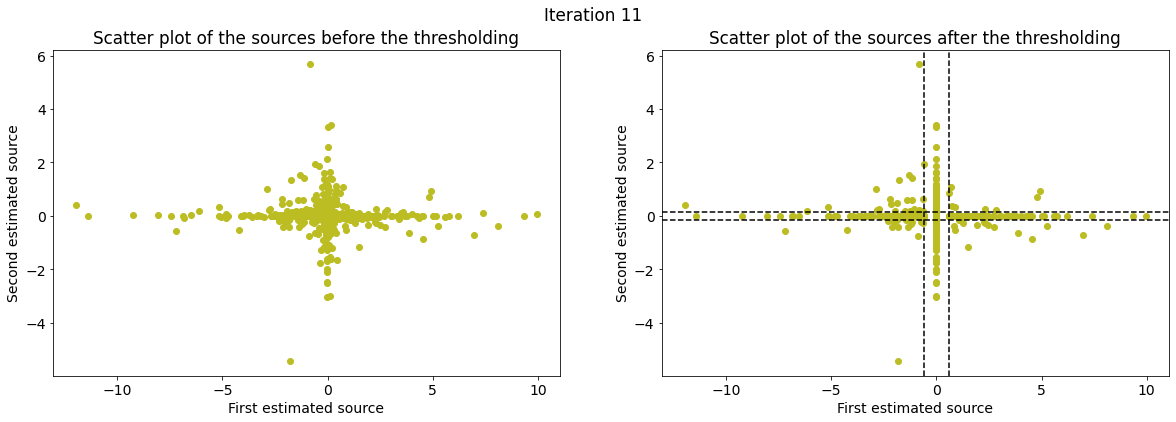

In [18]:
it = its[5]
it = np.int(it)
i += 1
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Iteration '+str(it))
fig.add_subplot(1,2,1)
plt.plot(Ss_gmca[it, 0, 0, :], Ss_gmca[it, 0, 1, :],'C'+str(i)+'o',zorder=0)
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources before the thresholding");
fig.add_subplot(1,2,2)
plt.plot(Ss_gmca[it, 1, 0, :], Ss_gmca[it, 1, 1, :],'C'+str(i)+'o',zorder=0)
plt.axhline(thrds[it, 1], color='k', linestyle='--')
plt.axhline(-thrds[it, 1], color='k', linestyle='--')
plt.axvline(thrds[it, 0], color='k', linestyle='--')
plt.axvline(-thrds[it, 0], color='k', linestyle='--')
plt.xlabel("First estimated source")
plt.ylabel("Second estimated source")
plt.title("Scatter plot of the sources after the thresholding");

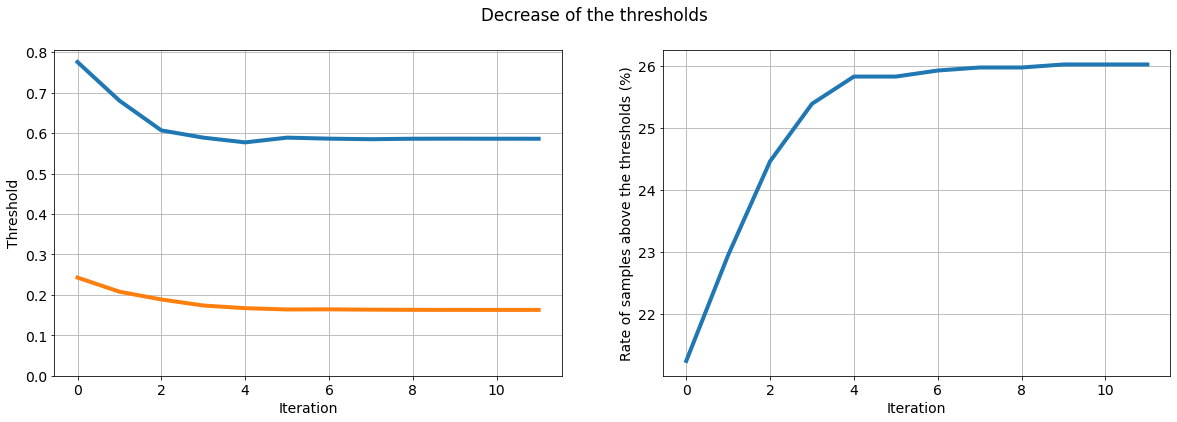

In [19]:
fig = plt.figure(figsize=(20, 6))
plt.suptitle('Decrease of the thresholds')
fig.add_subplot(1,2,1)
plt.plot(thrds[:, 0], linewidth=4)
plt.plot(thrds[:, 1], linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Threshold')
plt.grid()
plt.ylim(bottom=0);

fig.add_subplot(1,2,2)
plt.plot(np.sum(Ss_gmca[:, 1, :, :]!=0, axis=(1, 2))/(m*t)*100, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Rate of samples above the thresholds (%)')
plt.grid()

NMSE: 48.68 dB
CA: 26.62 dB


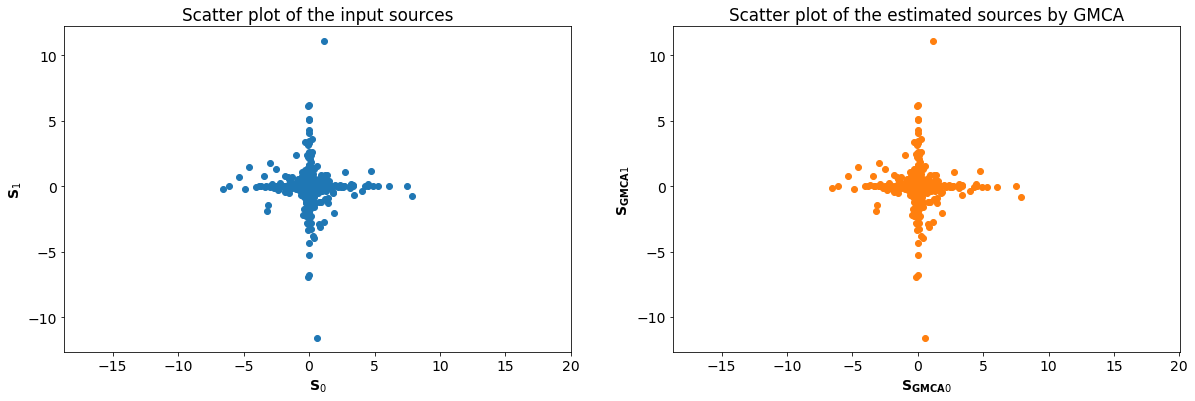

In [21]:
bss.corr_perm(A, S, A_gmca, S_gmca, inplace=True)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

fig.add_subplot(1,2,2)
plt.title('Scatter plot of the estimated sources by GMCA')
plt.plot(S_gmca[0,:], S_gmca[1,:],'C1o',zorder=0)
plt.xlabel("$\mathbf{S_{GMCA}}_0$")
plt.ylabel("$\mathbf{S_{GMCA}}_1$");
plt.axis('equal');

print("NMSE: %.2f dB" % bss.nmse(S, S_gmca))
print("CA: %.2f dB" % bss.ca(A, A_gmca))

This is a basic version of GMCA. Some simple procedures allow to significantly improve the results.

## 6. BSS with pictures

In this finale section, some of the BSS methods that we saw are tested on a mixture of pictures.

Let us load three pictures and plot them.

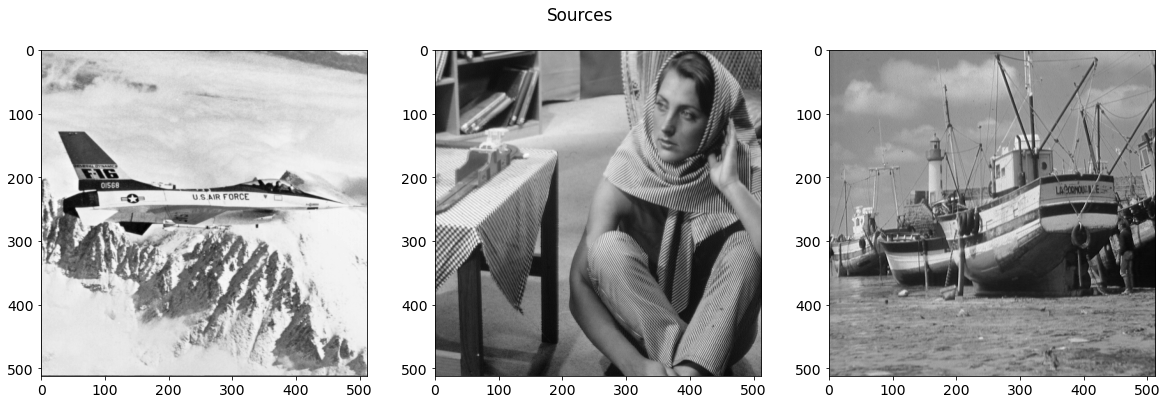

In [22]:
images = ['img/airplane.png', 'img/barbara.png', 'img/boat.png']
n = 3        # number of sources
p = 512**2   # number of samples

S = np.zeros((n, p))

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources')
for i in range(n):
    s = plt.imread(images[i])
    fig.add_subplot(1,3,i+1)
    plt.imshow(s, cmap=plt.get_cmap("gray"))
    S[i, :] = s.flatten()

The pictures are non-negative (and so is the mixing matrix which will be generated later). Thus, NMF methods can be used.



The pictures are not sparse. However, they are approximately sparse in the starlet domain (undecimated wavelet transform). Below are the histograms of the sources in the starlet space.

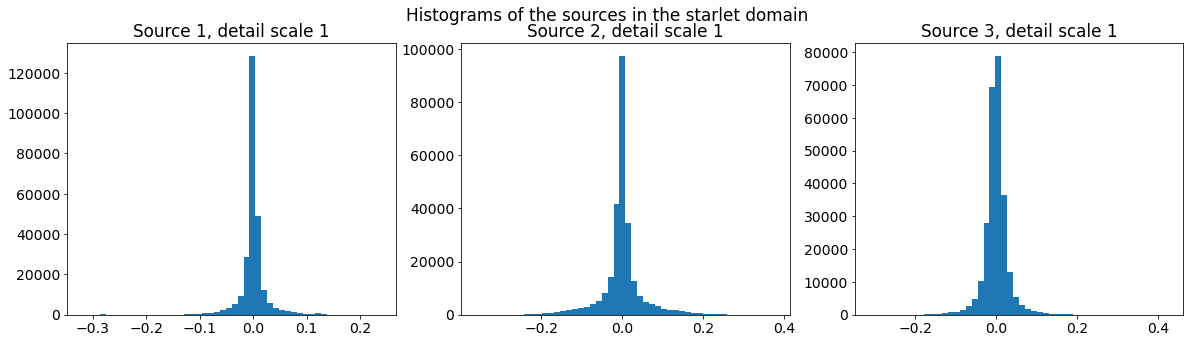

In [28]:
nscales = 1
S_wt = fftt.wt_trans(S, nscales=nscales)

fig = plt.figure(figsize=(20, 5))
plt.suptitle('Histograms of the sources in the starlet domain')
k = 0
for j in range(nscales):
    for i in range(n):
        k += 1
        fig.add_subplot(nscales, n, k)
        plt.hist(S_wt[i, :, j], bins=50)
        plt.title("Source %i, detail scale %i" % (i+1, j+1))

Let us generate 6 observations.

Mixing matrix condition number: 3.80


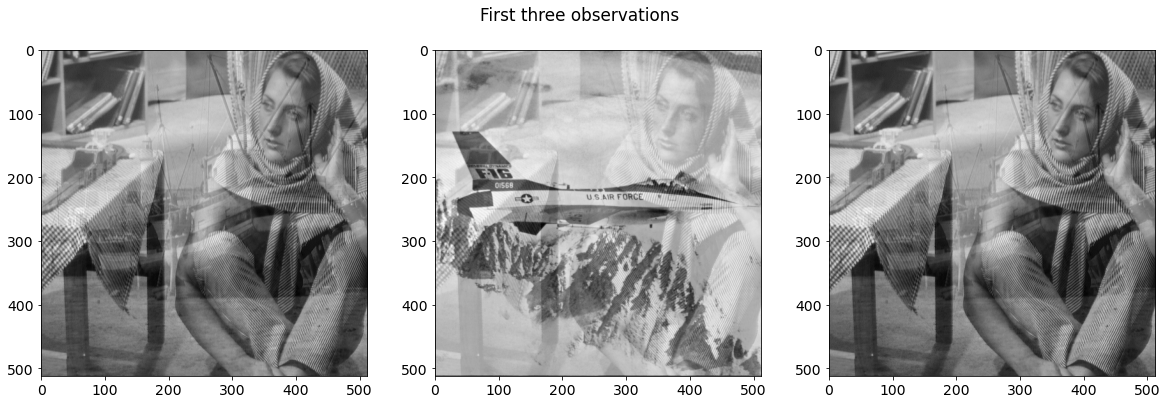

In [47]:
m = 2*n
while True:
    A = np.random.rand(m, n)
    if np.linalg.cond(A)<=5:
        break
print('Mixing matrix condition number: %.2f' % np.linalg.cond(A))

noise_level = 120

N = np.random.randn(m, p)
X = A@S + N*np.linalg.norm(S)*10**(-noise_level/20)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('First three observations')
for i in range(np.minimum(m, 3)):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(X[i, :], (512, 512)), cmap=plt.get_cmap("gray"))

Let us run and compare FastICA, the multiplicative update algorithm (NMF) and GMCA in the starlet domain.

Performances of ICA:
- NMSE: 6.62
- CA: 7.30


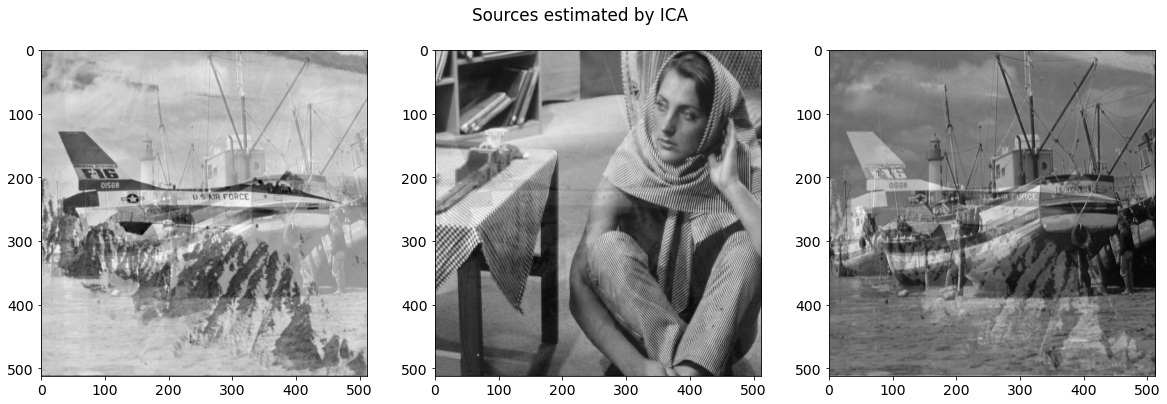

In [48]:
A_fpica, S_fpica = bss.fastica(X, n)
S_fpica = np.linalg.pinv(A_fpica)@X

bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by ICA')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_fpica[i, :], (512, 512)), cmap=plt.get_cmap("gray"))

print("Performances of ICA:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_fpica), bss.ca(A, A_fpica)))

Performances of multiplicative update algorithm:
- NMSE: 9.89
- CA: 4.09


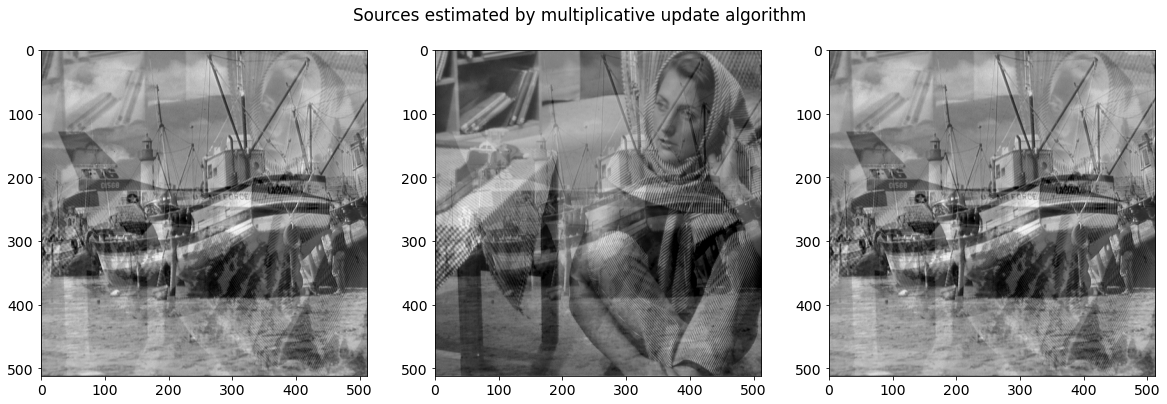

In [49]:
A_mu, S_mu = bss.multiplicative_update(X, n, nbIt=2000)

bss.corr_perm(A, S, A_mu, S_mu, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by multiplicative update algorithm')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_mu[i, :], (512, 512)), cmap=plt.get_cmap("gray"))
    
print("Performances of multiplicative update algorithm:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_mu), bss.ca(A, A_mu)))

Performances of GMCA:
- NMSE: 25.50
- CA: 18.22


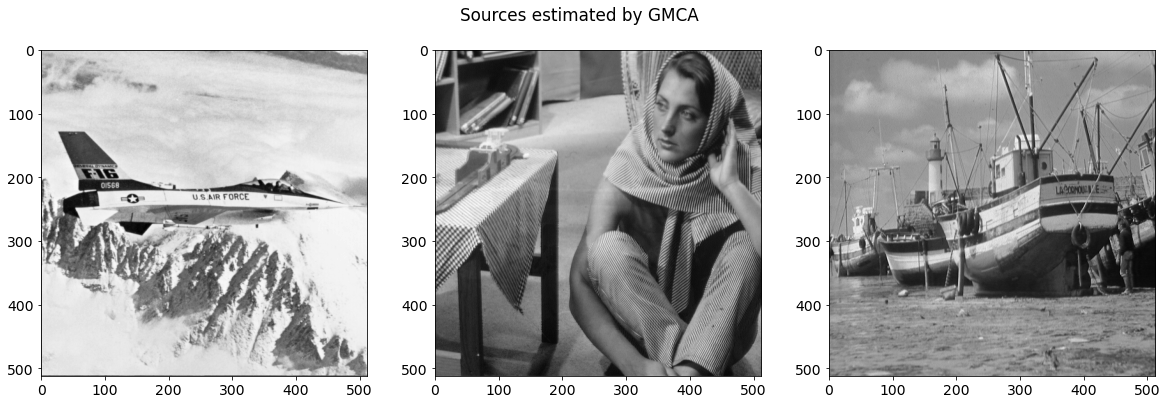

In [50]:
A_gmca, S_gmca = bss.gmca_starlet(X, n=n, nscales=nscales, nbItMin=20)
bss.corr_perm(A, S, A_gmca, S_gmca, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by GMCA')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_gmca[i, :], (512, 512)), cmap=plt.get_cmap("gray"))
    
print("Performances of GMCA:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_gmca), bss.ca(A, A_gmca)))

Let us finally see how these methods behave in the presence of noise.

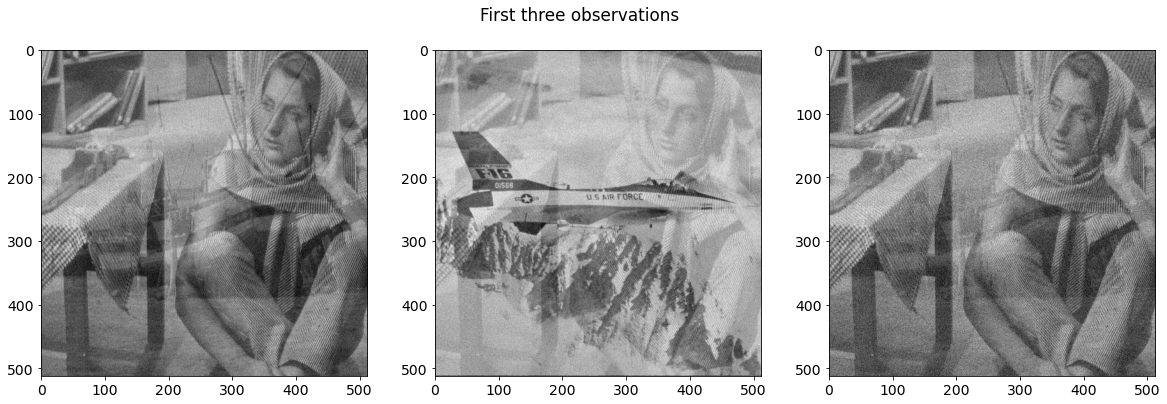

In [56]:
noise_level = 80

N = np.random.randn(m, p)
X = A@S + N*np.linalg.norm(S)*10**(-noise_level/20)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('First three observations')
for i in range(np.minimum(m, 3)):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(X[i, :], (512, 512)), cmap=plt.get_cmap("gray"))

Performances of ICA:
- NMSE: 5.11
- CA: 6.90


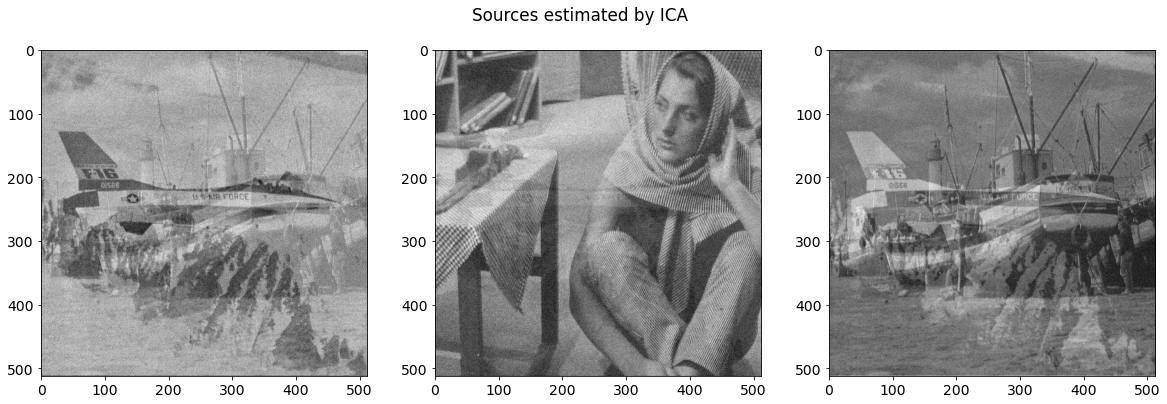

In [57]:
A_fpica, S_fpica = bss.fastica(X, n)
S_fpica = np.linalg.pinv(A_fpica)@X

bss.corr_perm(A, S, A_fpica, S_fpica, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by ICA')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_fpica[i, :], (512, 512)), cmap=plt.get_cmap("gray"))

print("Performances of ICA:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_fpica), bss.ca(A, A_fpica)))

Performances of multiplicative update algorithm:
- NMSE: 12.27
- CA: 7.28


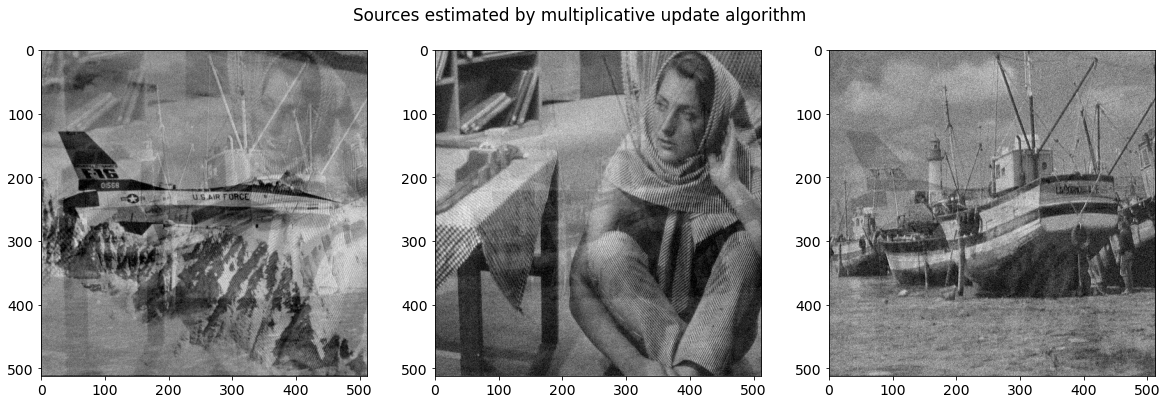

In [58]:
A_mu, S_mu = bss.multiplicative_update(X, n, nbIt=2000)

bss.corr_perm(A, S, A_mu, S_mu, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by multiplicative update algorithm')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_mu[i, :], (512, 512)), cmap=plt.get_cmap("gray"))
    
print("Performances of multiplicative update algorithm:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_mu), bss.ca(A, A_mu)))

Performances of GMCA:
- NMSE: 17.73
- CA: 10.22


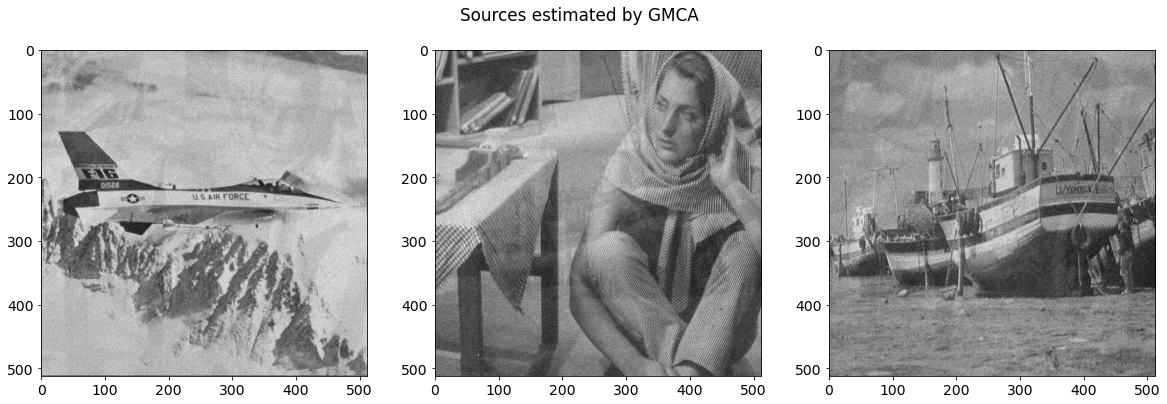

In [59]:
A_gmca, S_gmca = bss.gmca_starlet(X, n=n, nscales=nscales)
bss.corr_perm(A, S, A_gmca, S_gmca, inplace=True)

fig = plt.figure(figsize=(20, 6))
plt.suptitle('Sources estimated by GMCA')
for i in range(n):
    fig.add_subplot(1,3,i+1)
    plt.imshow(np.reshape(S_gmca[i, :], (512, 512)), cmap=plt.get_cmap("gray"))
    
print("Performances of GMCA:\n- NMSE: %.2f\n- CA: %.2f" % (bss.nmse(S, S_gmca), bss.ca(A, A_gmca)))